# Tests and Figures for Attention Window Size CUDA Kernel

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas
import torch

from skipformer.attention_window_cuda import awmm_cuda
from scipy import stats
from tqdm import tqdm
from torch.utils.cpp_extension import load

Detected CUDA files, patching ldflags
Emitting ninja build file /home/mbodenham/github/skipformer/skipformer/attention_window_cuda/build/build.ninja...
Building extension module attention_window_matmul...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module attention_window_matmul...


In [2]:
awmm_no_wm_cuda = load(name='attention_window_matmul_no_wm',
                 sources=['skipformer/attention_window_cuda/attention_window_matmul.cpp',
                          'skipformer/attention_window_cuda/attention_window_matmul_no_wm_kernel.cu',],
                 build_directory='skipformer/attention_window_cuda/build',
                 verbose=True)

Detected CUDA files, patching ldflags
Emitting ninja build file skipformer/attention_window_cuda/build/build.ninja...
Building extension module attention_window_matmul_no_wm...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module attention_window_matmul_no_wm...


## Test Latency

In [3]:
def mean_times(times):
    z_score = stats.zscore(times)
    times = times[(-3<z_score) & (z_score<3)]
    return times.mean()

def time_matmul(batch_sz, n_heads, N, d_model, ws=16, repetitions=1, passes=1, device=torch.device('cuda'), verbose=False):

    d_k = d_model // n_heads 
    q = torch.rand([batch_sz, n_heads, N, d_k], device=device, dtype=torch.float)
    k_t = torch.rand([batch_sz, n_heads, d_k, N], device=device, dtype=torch.float)
    wm = torch.ones([N, N], device=device, dtype=torch.float)
    ws_ = torch.tensor([ws]*n_heads, device=device, dtype=torch.float)

    for i in range(repetitions//10):
        qk_t = torch.matmul(q, k_t)


    time_torch = np.zeros(passes)
    time_custom = np.zeros(passes)
    time_custom_no_mask = np.zeros(passes)
    for p in range(passes):
        with torch.cuda.device(device):
            with torch.no_grad():
                torch.backends.cudnn.benchmark = True

                starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
                timings = torch.zeros(repetitions, device=device)

                for rep in tqdm(range(repetitions), desc='torch.matmul', disable=not verbose):
                    starter.record(torch.cuda.current_stream(device))
                    qk_t = torch.matmul(q, k_t)
                    ender.record(torch.cuda.current_stream(device))

                    torch.cuda.synchronize(device)

                    timings[rep] = starter.elapsed_time(ender)
                    starter.elapsed_time(ender)


                time_torch[p] = mean_times(timings.cpu().detach().numpy())

                
                starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
                timings = torch.zeros(repetitions, device=device)

                for rep in tqdm(range(repetitions), desc='custom', disable=not verbose):
                    starter.record(torch.cuda.current_stream(device))
            
                    qk_t = awmm_no_wm_cuda.forward(q, k_t, ws_, wm, True)
                    ender.record(torch.cuda.current_stream(device))

                    torch.cuda.synchronize(device)

                    timings[rep] = starter.elapsed_time(ender)
                    starter.elapsed_time(ender)

                time_custom[p] = mean_times(timings.cpu().detach().numpy())
                
                
                starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
                timings = torch.zeros(repetitions, device=device)

                for rep in tqdm(range(repetitions), desc='custom', disable=not verbose):
                    starter.record(torch.cuda.current_stream(device))
            
                    qk_t = awmm_no_wm_cuda.forward(q, k_t, ws_, wm, False)
                    ender.record(torch.cuda.current_stream(device))

                    torch.cuda.synchronize(device)

                    timings[rep] = starter.elapsed_time(ender)
                    starter.elapsed_time(ender)

                time_custom_no_mask[p] = mean_times(timings.cpu().detach().numpy())
        

    
    return {'window_size': ws, 
            'torch.matmul': time_torch.mean(), 
            'custom masked': time_custom.mean(), 
            'custom not masked': time_custom_no_mask.mean()}

  
time_matmul(1, 12, 512, 64, ws=16, repetitions=10)

{'window_size': 16,
 'torch.matmul': 13.723126411437988,
 'custom masked': 9.456411361694336,
 'custom not masked': 10.857765197753906}

In [4]:
N = 1024
n_heads = 12
d_model = 768
d_k = d_model // n_heads 
batch_sz = 1
device = torch.device("cuda:0")

window_sizes = [2**i for i in range(2,11)] + [2**i+(2**i)//2 for i in range(6,10)] + [80, 112, 160, 640, 896]
data = []
for ws in tqdm(window_sizes):
    results = time_matmul(batch_sz, n_heads, N, d_model, ws=ws, repetitions=400, passes=1, device=device)
    data.append(results)
    
df = pandas.DataFrame(data).groupby('window_size').mean()
df

100%|██████████| 18/18 [04:45<00:00, 15.86s/it]


,torch.matmul,custom masked,custom not masked
window_size,,,
4,12.051633,6.595927,8.234614
8,12.086092,6.585763,8.260004
16,12.095052,6.642622,8.229184
32,12.126997,6.569517,8.034803
64,12.146460,6.542494,8.091249
80,12.172118,6.869619,8.663265
96,12.128233,6.855038,8.740254
112,12.173432,6.884517,8.780908
128,12.117301,6.878726,8.741269


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:2019: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:251: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


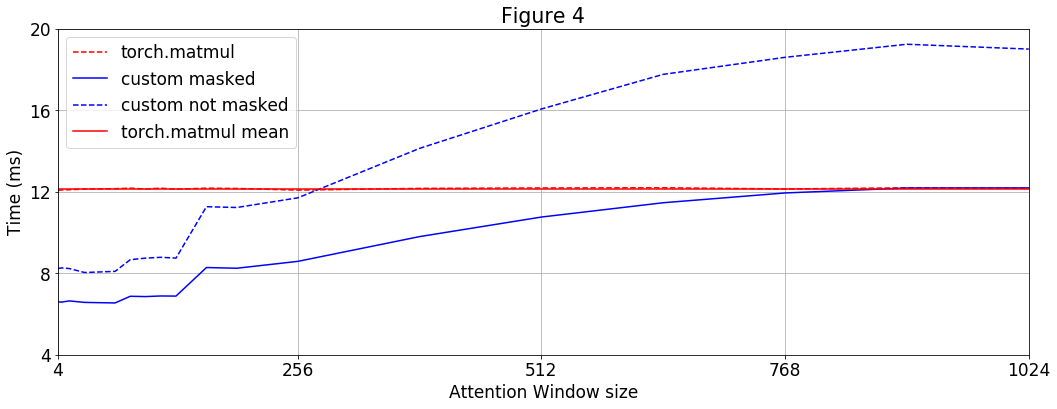

In [5]:
plt.rcParams["font.size"] = "17"
plt.figure(figsize=(15, 6))

styles={'torch.matmul': 'r--', 
        'custom masked': 'b-', 
        'custom not masked': 'b--'}

for label in df.columns.values:
    plt.plot(df.index.values,
             df[label],
             styles[label],
             label=label)
    
plt.xlabel("Attention Window size", fontsize=17)
plt.ylabel("Time (ms)", fontsize=17)
plt.title("Figure 4")
    
plt.xlim(4,1024)
plt.xticks([4]+[256*i for i in range(1,5)])
plt.ylim(4,20)
plt.yticks([4*i for i in range(1,6)])
plt.axhline(y=df["torch.matmul"].mean(), color='red', linestyle='-', label='torch.matmul mean')

plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

## Test Accuracy

In [6]:
def generate_square_subsequent_mask(src_sz: int, tgt_sz: int) -> torch.Tensor:
    mask = (torch.triu(torch.ones(src_sz, tgt_sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    # mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def gen_window_mask(M, window_size, masked=True):
    window_mask = torch.zeros(N, N, device=device)
    if masked:
        for i in range(N):
            for j in range(N):
                if i - j < window_size and i >= j:
                    window_mask[i,j] = 1
    else:
        for i in range(N):
            for j in range(N):
                if (i - window_size) < j and j < (i + window_size):
                    window_mask[i,j] = 1
    return window_mask

In [7]:
masked = True
N=128

d_k = d_model // n_heads 
q = torch.rand([batch_sz, n_heads, N, d_k], device=device, dtype=torch.float)
k_t = torch.rand([batch_sz, n_heads, d_k, N], device=device, dtype=torch.float)
wm = torch.ones([N, N], device=device, dtype=torch.float)
mask = generate_square_subsequent_mask(N, N).to(device) if masked else 0

close = torch.zeros(N, device=device, dtype=torch.bool)
for ws in tqdm(range(1, N+1)):
    ws_ = torch.tensor([ws]*n_heads, device=device, dtype=torch.float)
    window_mask = gen_window_mask(N, ws, masked)
    
    mm_out = torch.matmul(q, k_t)*window_mask+mask
    awmm_out = awmm_no_wm_cuda.forward(q,
                                       k_t,
                                       ws_,
                                       wm,
                                       masked)+mask
    
    close[ws-1] = torch.allclose(mm_out, awmm_out)
    if not close[ws-1]:
        print(ws)
    
print(close.all())

100%|██████████| 128/128 [01:02<00:00,  2.04it/s]

tensor(True, device='cuda:0')
